In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from micron2.data import stream_dataset

import tqdm.auto as tqdm

from tensorflow.keras.layers import (Dense, Conv2D, Dropout, BatchNormalization, Conv2DTranspose)

ModuleNotFoundError: No module named 'micron2.codexutils.pull_nuclei'

In [ ]:
import h5py
f = h5py.File('/dev/shm/dataset.hdf5', 'r')
print(f['meta/channel_names'][:])
use_channels = [b.decode('UTF-8') for b in f['meta/channel_names'][:]]
# fn = lambda x,y: print(x)
print(f.keys())
print(f['cells'].keys())
f.close()

In [3]:
# x = load_dataset('tests/dataset.hdf5', use_channels=['DAPI', 'CD45', 'PanCytoK', 'CD31', 'PDGFRb', 'aSMA', 'Ki-67'],
#                  verbose=True)
# print(x.shape)

print(use_channels)
def process(x):
    x = tf.cast(x, tf.float32)/255.
    return x
    
dataset = stream_dataset('/dev/shm/dataset.hdf5', use_channels=use_channels)
dataset = (dataset.repeat(10)
           .shuffle(1024 * 6)
           .map(process)
           .batch(16)
           .prefetch(8)
           #.apply(tf.data.experimental.prefetch_to_device("/gpu:0"))
          )

for sample_x in dataset:
    break
    
print(sample_x.shape)
for k in range(sample_x.shape[-1]):
    print(sample_x.numpy()[...,k].sum())

(16, 64, 64, 3)
1796.6393
420.52942
86.435295


In [4]:
class Autoencoder(tf.keras.Model):
    def __init__(self, input_shape=[64, 64, 3]):
        super(Autoencoder, self).__init__()
        self.n_channels = input_shape[-1]
        self.n_upsamples = 7
        self.conv_1 = tf.keras.applications.ResNet50V2(include_top=False, weights=None,
                                                       input_shape=input_shape,
                                                       pooling='average')
        self.conv_2 = Conv2D(filters=256, kernel_size=(2,2), strides=(1,1), 
                             padding='same', activation='relu')
        
        self.g_fn = Dense(32, activation=None, name='g_simclr')
        
        self.build_upsample(name='up_large')
        self.build_upsample(name='up_small')
        
    def build_upsample(self, name='upsample'):
        p_act = dict(padding='same', activation='relu')
        setattr(self, f'{name}_0', Conv2DTranspose(filters=256,  kernel_size=(2,2),
                                        strides=(2,2), **p_act))
        setattr(self, f'{name}_1', Conv2DTranspose(filters=128,  kernel_size=(3,3),
                                        strides=(2,2), **p_act))
        setattr(self, f'{name}_2', Conv2DTranspose(filters=64,  kernel_size=(5,5),
                                        strides=(2,2), **p_act))
        setattr(self, f'{name}_3', Conv2DTranspose(filters=64,  kernel_size=(5,5),
                                        strides=(2,2), **p_act))
        setattr(self, f'{name}_4', Conv2DTranspose(filters=64,  kernel_size=(3,3),
                                        strides=(1,1), **p_act))
        setattr(self, f'{name}_5', Conv2DTranspose(filters=self.n_channels,  kernel_size=(5,5),
                                        strides=(2,2), **p_act))
        setattr(self, f'{name}_6', Conv2DTranspose(filters=self.n_channels,  kernel_size=(3,3),
                                        strides=(1,1), **p_act))
        
    def apply_upsample(self, z, name='upsample'):
        for j in range(self.n_upsamples):
            z = getattr(self, f'{name}_{j}')(z)
        return z
        
    def call(self, x, return_g=False):
        x1 = self.conv_1(x)
        x2 = self.conv_2(x1)
        
        # Two parallel upsampling paths
        x1u = self.apply_upsample(x1, name='up_large')
        x2u = self.apply_upsample(x2, name='up_small')

        xout = tf.reduce_mean([x1u, x2u], axis=0)
        xout = tf.image.resize_with_crop_or_pad(xout, x.shape[1], x.shape[2])
        if return_g:
            g = self.g_fn(tf.reduce_mean(x2, axis=[1,2]))
            return xout, g
        return xout  
    
    def encode_g(self, x):
        # Apply g function for simclr
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = tf.reduce_mean(x, axis=[1,2])
        x = self.g_fn(x)
        return x
    
    def encode(self, x, retval=1):
        if retval == 0:
            x = self.conv_1(x)
        elif retval == 1:
            x = self.conv_1(x)
            x = self.conv_2(x)
            
        return tf.reduce_mean(x, axis=[1,2])
        
sample_x = tf.image.random_crop(sample_x, size=(sample_x.shape[0], 48, 48, sample_x.shape[-1]))
ae_model = Autoencoder(input_shape=sample_x.shape[1:])
y = ae_model(sample_x)
print(y.shape)
z = ae_model.encode(sample_x)
print(z.shape)
z_g = ae_model.encode_g(sample_x)
print(z_g.shape)

(16, 48, 48, 3)
(16, 256)
(16, 32)


In [5]:
ae_model.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2, 2, 2048)        23564800  
_________________________________________________________________
conv2d (Conv2D)              multiple                  2097408   
_________________________________________________________________
g_simclr (Dense)             multiple                  8224      
_________________________________________________________________
conv2d_transpose (Conv2DTran multiple                  2097408   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr multiple                  295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr multiple                  204864    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr multiple                  

In [22]:
# Normal training -- autoencoder only
def train_loop(dataset, model):
    mse_fn = tf.keras.losses.MeanSquaredError()
    optim = tf.keras.optimizers.Adam(learning_rate = 1e-4)

    pbar = tqdm.tqdm(enumerate(dataset))

    losses = []
    for i, batch in pbar:
        with tf.GradientTape() as tape:
            xout = model(batch)
            loss = mse_fn(batch, xout)
        losses.append(loss.numpy())
        grads = tape.gradient(loss, model.trainable_variables)
        optim.apply_gradients(zip(grads, model.trainable_variables))

        if i % 100 == 0:
            pbar.set_description(f'mean loss = {np.mean(losses):3.5e}')
            losses = []
            
train_loop(dataset, ae_model)

KeyboardInterrupt: 

In [7]:
# Autoencoder only but with gradient accumulation
def train_loop_grad_accum(dataset, model):
    mse_fn = tf.keras.losses.MeanSquaredError()
    optim = tf.keras.optimizers.Adam(learning_rate = 1e-4)
    pbar = tqdm.tqdm(enumerate(dataset))
    losses = []
    grad_dict = {v.name: [] for v in model.trainable_variables}
    
    def stash_grads(grads, grad_dict, trainable_variables):
        for i, v in enumerate(trainable_variables):
            grad_dict[v.name].append(grads[i])
    
    def mean_grads(grad_dict, trainable_variables):
        grads = [tf.reduce_mean(grad_dict[v.name], axis=0) for v in trainable_variables]
        return grads
    
    for i, batch in pbar:
        with tf.GradientTape() as tape:
            xout = model(batch)
            loss = mse_fn(batch, xout)
        losses.append(loss.numpy())
        grads = tape.gradient(loss, model.trainable_variables)
        
        stash_grads(grads, grad_dict, model.trainable_variables)
        if i % 32 == 0:
            grads = mean_grads(grad_dict, model.trainable_variables)
            optim.apply_gradients(zip(grads, model.trainable_variables))
            grad_dict = {v.name: [] for v in model.trainable_variables}
            
        if i % 100 == 0:
            pbar.set_description(f'mean loss = {np.mean(losses):3.5e}')
            losses = []
            
train_loop_grad_accum(dataset, ae_model)

KeyboardInterrupt: 

In [6]:
def similarity(u, tau=1.0):
    nu = tf.norm(u, ord=2, keepdims=True, axis=-1)
    sim = tf.tensordot(u, tf.transpose(u), 1) 
    return sim / (tf.constant(1e-9) + (tau * nu * tf.transpose(nu)))


def simclr_loss_fn(z_i, tau=1.):
    """
    A Simple Framework for Contrastive learning of Visual Representations
    Ting Chen, Simon Kornblith, Mohammad Norouzi, Geoffrey Hinton, 2020.  
    https://arxiv.org/abs/2002.05709
    """

    s = tf.exp(similarity(z_i, tau=tau))
    i_part, j_part = tf.split(s, 2, 0)

    total_i = tf.reduce_sum(i_part, axis=-1) - tf.linalg.diag_part(i_part)
    total_j = tf.reduce_sum(j_part, axis=-1) - tf.linalg.diag_part(j_part)

    l_i = -tf.math.log( tf.linalg.diag_part(i_part) / total_i )
    l_j = -tf.math.log( tf.linalg.diag_part(j_part) / total_j )

    loss = tf.reduce_sum(l_i + l_j)
    return loss
    

def perturb_x(x):
    x = tf.image.random_crop(x, size=(x.shape[0], 48, 48, x.shape[-1]))
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return x
    
    
# Autoencoder + simCLR. Use gradient accumulation for simCLR loss. 
# Autoencoder is trained every step
def train_AE_simCLR(dataset, model):
    mse_fn = tf.keras.losses.MeanSquaredError()
    optim = tf.keras.optimizers.Adam(learning_rate = 1e-4)
    simclr_optim = tf.keras.optimizers.Adam(learning_rate = 1e-4)
    pbar = tqdm.tqdm(enumerate(dataset))
    losses, sc_losses = [], []
    prev_loss, prev_sc_loss = 0, 0
    
    def stash_grads(grads, grad_dict, trainable_variables):
        for i, v in enumerate(trainable_variables):
            if grads[i] is None:
                grad_dict[v.name].append(tf.zeros(v.shape, dtype=tf.float32))
            else:
                grad_dict[v.name].append(grads[i])
    
    def mean_grads(grad_dict, trainable_variables):
        grads = [tf.reduce_mean(grad_dict[v.name], axis=0) for v in trainable_variables]
        return grads
    
    # Grab variables for the AE portion because otherwise theres tons of warnings
    ae_vars = [v for v in ae_model.trainable_variables if 'g_simclr' not in v.name]
    
    grad_dict = {v.name: [] for v in model.trainable_variables}
    for i, batch in pbar:
        batch_in = tf.image.random_crop(batch, size=(batch.shape[0], 48, 48, batch.shape[-1]))
        batch_p = perturb_x(batch)
        with tf.GradientTape(persistent=True) as tape:
            xout1, g1 = model(batch_in, return_g=True)
            xout2, g2 = model(batch_p, return_g=True)
            
            mse_loss = mse_fn(tf.concat([batch_in, batch_p], axis=0), 
                              tf.concat([xout1, xout2], axis=0))
            l_simclr = simclr_loss_fn(tf.concat([g1, g2], axis=0), tau=0.1)
            
        losses.append(mse_loss.numpy())
        sc_losses.append(l_simclr.numpy())
        mse_grads = tape.gradient(mse_loss, ae_vars)
        simclr_grads = tape.gradient(l_simclr, model.trainable_variables)
        del tape
        
        optim.apply_gradients(zip(mse_grads, ae_vars))
        stash_grads(simclr_grads, grad_dict, model.trainable_variables)
        if i % 16 == 0:
            simclr_grads = mean_grads(grad_dict, model.trainable_variables)
            simclr_optim.apply_gradients(zip(simclr_grads, model.trainable_variables))
            grad_dict = {v.name: [] for v in model.trainable_variables}
            
        if i % 100 == 0:
            m_loss = np.mean(losses)
            m_sc_losses = np.mean(sc_losses)
            #pbar.set_description(f'mse_loss = {np.mean(losses):3.5e} simclr_loss = {np.mean(sc_losses):3.5e}')
            pbar.set_description(f'd(mse_loss) = {prev_loss-m_loss:3.5e}\td(simclr_loss) = {prev_sc_loss-m_sc_losses:3.5e}')
            prev_loss = np.mean([prev_loss, m_loss])
            prev_sc_loss = np.mean([prev_sc_loss, m_sc_losses])
            losses, sc_losses = [], []
            
train_AE_simCLR(dataset, ae_model)

In [18]:
def process(x):
    # x = tf.image.random_crop(x, size=(x.shape[0], 48, 48, x.shape[-1]))
    x = tf.cast(x, tf.float32)/255.
    return x
    
# use_channels=['DAPI', 'CD45', 'PanCytoK']
# use_channels=['DAPI', 'CD45', 'PanCytoK', 'CD31', 'PDGFRb', 'aSMA', 'Ki-67']
dataset = stream_dataset('tests/dataset.hdf5', use_channels = use_channels)
dataset = (dataset.map(process)
           .batch(64)
          )

z = []
for batch in tqdm.tqdm(dataset):
    z.append(ae_model.encode_g(batch).numpy().copy())
    
z = np.concatenate(z, axis=0)
print(z.shape)
print((z.sum(0)==0).sum())


(146791, 256)
44


In [ ]:
outdir = 'simclr_model'
np.save(f'{outdir}/z.npy', z)
ae_model.save_weights(f"{outdir}/weights.h5")

channel 0	pred 1013.63	real 1028.78
channel 1	pred 290.24	real 257.13
channel 2	pred 0.00	real 43.75
5 0
0 63.411766 62.488564


<Figure size 432x288 with 0 Axes>

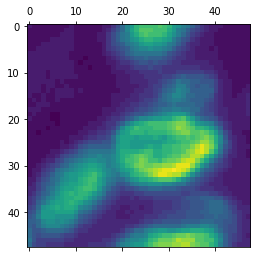

<Figure size 432x288 with 0 Axes>

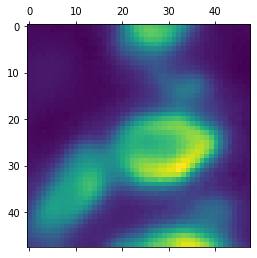

In [17]:
from matplotlib import pyplot as plt
sample_xout = ae_model(sample_x)
for j in range(sample_x.shape[-1]):
    print(f'channel {j}\t' +\
          f'pred {tf.reduce_sum(sample_xout[...,j]).numpy():<4.2f}\t' +\
          f'real {tf.reduce_sum(sample_x[...,j]).numpy():<4.2f}')

idx = np.random.choice(sample_xout.shape[0])
jdx = np.random.choice(sample_xout.shape[-1])

jdx = 0

print(idx, jdx)
sx = sample_x.numpy()[idx, :,:, jdx]
sxout = sample_xout.numpy()[idx, :,:, jdx] 
print(jdx, sx.sum(), sxout.sum())

plt.figure()
plt.matshow(sx)# / sx.max())

plt.figure()
plt.matshow(sxout)# / sxout.max())